In [ ]:
import cv2
import os
import glob
import time
import pickle
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog

BASE_DIR = 'dataset'
MODEL_SAVE_PATH = 'model_svm.pkl'

HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': False,
}

LABELS = {'vehicle': 1, 'non': 0}

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess_image(img):
    img_float = img.astype(np.float32) / 255.0
    img_gamma = np.sqrt(img_float)
    img_gamma = (img_gamma * 255).astype(np.uint8)

    img_blur = cv2.GaussianBlur(img_gamma, (5,5), sigmaX=0.8)

    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    gray_clahe = clahe.apply(gray)

    return cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2BGR)

def get_hog_features(img, params):
    if img is None:
        return None
    if img.ndim == 3:
        img = preprocess_image(img)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = preprocess_image(img)
        img_gray = img

    if img_gray.shape != (64, 64):
        img_gray = cv2.resize(img_gray, (64, 64))

    try:
        features = hog(img_gray,
                       orientations=params['orientations'],
                       pixels_per_cell=params['pixels_per_cell'],
                       cells_per_block=params['cells_per_block'],
                       transform_sqrt=params['transform_sqrt'],
                       feature_vector=True,
                       channel_axis=None)
        return features
    except:
        return None

print("🚀 TRAINING DENGAN 45 IMAGES")
print("=" * 50)

X = []
y = []

for label_name, label_id in LABELS.items():
    folder_path = os.path.join(BASE_DIR, label_name)
    image_paths = glob.glob(os.path.join(folder_path, "*.png"))

    print(f"📁 {label_name}: {len(image_paths)} images")

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            features = get_hog_features(img, HOG_PARAMS)
            if features is not None:
                X.append(features)
                y.append(label_id)

X = np.array(X)
y = np.array(y)

print(f"\n📊 DATA SUMMARY:")
print(f"   Total: {len(X)} images")
print(f"   Vehicle: {np.sum(y == 1)}")
print(f"   Non-vehicle: {np.sum(y == 0)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📈 DATA SPLIT:")
print(f"   Training: {len(X_train)} images")
print(f"   Testing:  {len(X_test)} images")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n⚙️ TRAINING SVM...")
t_start = time.time()

svc = LinearSVC(
    C=0.01,
    # dual='auto',
    random_state=42,
    max_iter=5000
)
svc.fit(X_train_scaled, y_train)

t_end = time.time()
print(f"   ✅ Training selesai: {t_end - t_start:.2f} detik")

train_accuracy = svc.score(X_train_scaled, y_train)
test_accuracy = svc.score(X_test_scaled, y_test)

print(f"\n🎯 HASIL TRAINING:")
print(f"   Akurasi Training: {train_accuracy:.3f}")
print(f"   Akurasi Testing:  {test_accuracy:.3f}")

train_scores = svc.decision_function(X_train_scaled)
test_scores = svc.decision_function(X_test_scaled)

print(f"\n📊 CONFIDENCE RANGE:")
print(f"   Training: [{train_scores.min():.2f}, {train_scores.max():.2f}]")
print(f"   Testing:  [{test_scores.min():.2f}, {test_scores.max():.2f}]")

model_data = {
    'svc': svc,
    'scaler': scaler,
    'params': HOG_PARAMS,
    'labels': LABELS,
    'confidence_range': {
        'min': float(test_scores.min()),
        'max': float(test_scores.max())
    }
}

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\n💾 Model disimpan: {MODEL_SAVE_PATH}")
print("=" * 50)

🚀 TRAINING DENGAN 45 IMAGES
📁 vehicle: 724 images
📁 non: 4135 images

📊 DATA SUMMARY:
   Total: 4859 images
   Vehicle: 724
   Non-vehicle: 4135

📈 DATA SPLIT:
   Training: 3887 images
   Testing:  972 images

⚙️ TRAINING SVM...
   ✅ Training selesai: 2.57 detik

🎯 HASIL TRAINING:
   Akurasi Training: 1.000
   Akurasi Testing:  0.971

📊 CONFIDENCE RANGE:
   Training: [-4.61, 5.36]
   Testing:  [-4.38, 5.36]

💾 Model disimpan: /kaggle/working/model_svm.pkl


🚀 TRAINING DAN KOMPARASI MULTI-MODEL
📁 vehicle: 724 images
📁 non: 4135 images

📊 DATA SUMMARY:
   Total: 4859 images
   Vehicle: 724
   Non-vehicle: 4135

📈 DATA SPLIT:
   Training: 3887 images
   Testing:  972 images

🤖 MEMPERSIAPKAN MODEL UNTUK KOMPARASI...

⚙️ MELATIH SEMUA MODEL...
------------------------------------------------------------
Training Linear SVM...
  ✅ Test Accuracy: 0.971, Training Time: 2.56s
Training Decision Tree...
  ✅ Test Accuracy: 0.913, Training Time: 3.16s
Training Random Forest...
  ✅ Test Accuracy: 0.923, Training Time: 5.45s

💾 Hasil komparasi disimpan: /kaggle/working/model_comparison_results.csv
💾 Grafik disimpan: /kaggle/working/recognition_rate_comparison.png

📊 ANALISIS DETAIL MODEL SVM

🎯 MELATIH LINEAR SVM DENGAN PARAMETER OPTIMAL...

✅ HASIL LINEAR SVM:
   Accuracy: 0.971
   Confusion Matrix:
[[815  12]
 [ 16 129]]

   Classification Report:
              precision    recall  f1-score   support

 Non-Vehicle       0.98      0.99      0.98       

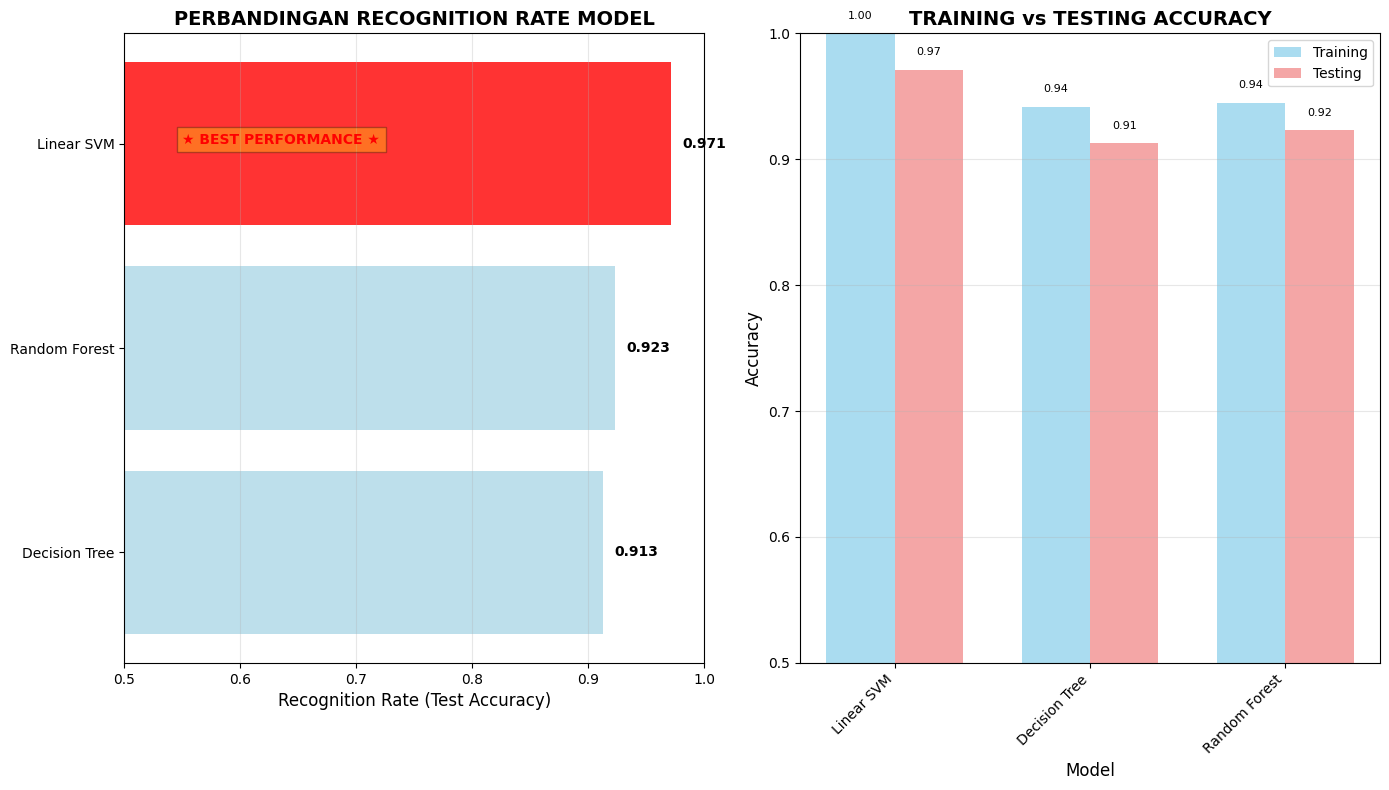

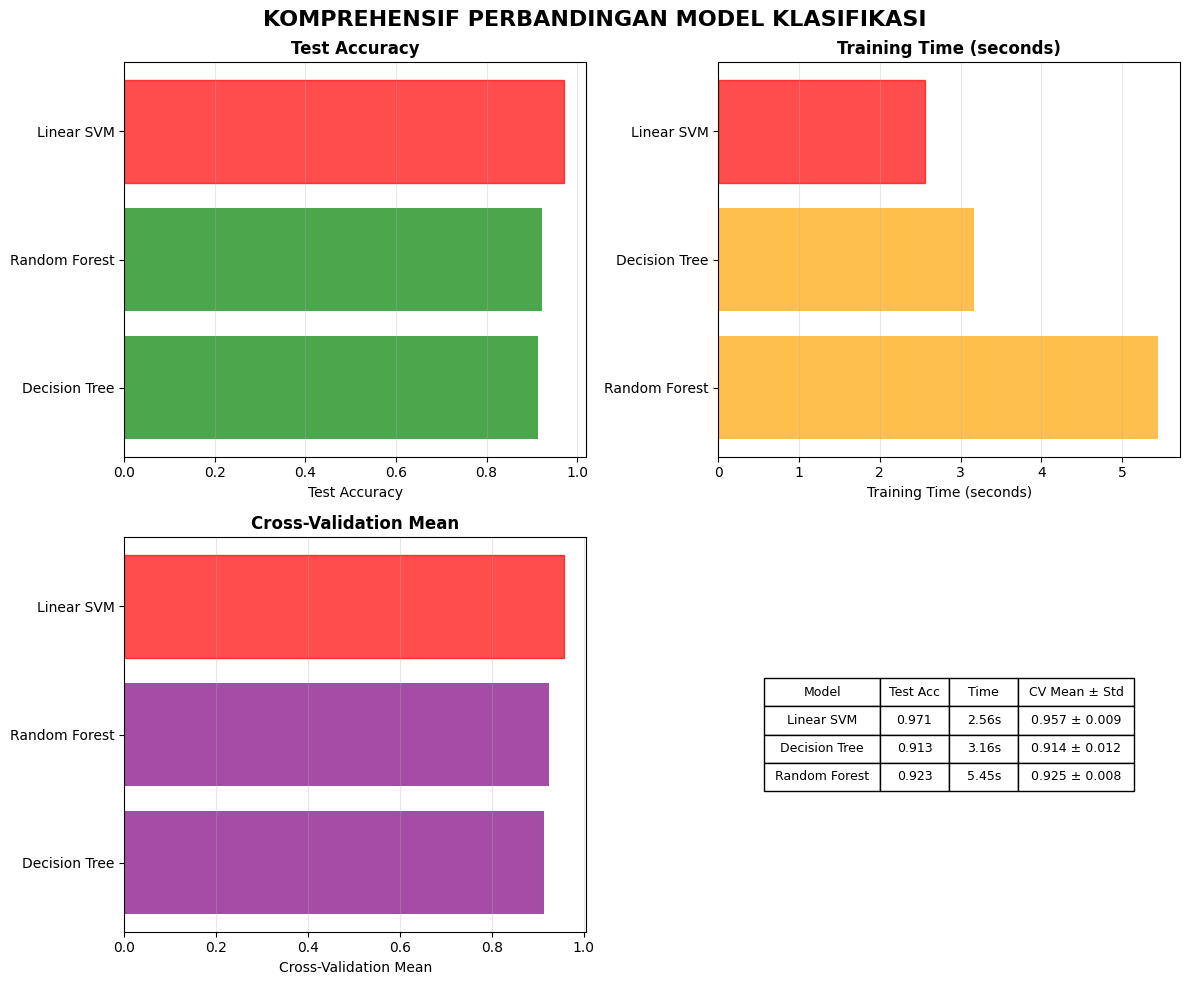

In [ ]:
import cv2
import os
import glob
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from skimage.feature import hog

BASE_DIR = 'dataset'
MODEL_SAVE_PATH = 'model_svm.pkl'
GRAPH_SAVE_PATH = 'recognition_rate_comparison.png'
RESULTS_SAVE_PATH = 'model_comparison_results.csv'

HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': False,
}

LABELS = {'vehicle': 1, 'non': 0}

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess_image(img):
    img_float = img.astype(np.float32) / 255.0
    img_gamma = np.sqrt(img_float)
    img_gamma = (img_gamma * 255).astype(np.uint8)

    img_blur = cv2.GaussianBlur(img_gamma, (5,5), sigmaX=0.8)

    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    gray_clahe = clahe.apply(gray)

    return cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2BGR)

def get_hog_features(img, params):
    if img is None:
        return None
    if img.ndim == 3:
        img = preprocess_image(img)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = preprocess_image(img)
        img_gray = img

    if img_gray.shape != (64, 64):
        img_gray = cv2.resize(img_gray, (64, 64))

    try:
        features = hog(img_gray,
                       orientations=params['orientations'],
                       pixels_per_cell=params['pixels_per_cell'],
                       cells_per_block=params['cells_per_block'],
                       transform_sqrt=params['transform_sqrt'],
                       feature_vector=True,
                       channel_axis=None)
        return features
    except:
        return None

print("🚀 TRAINING DAN KOMPARASI MULTI-MODEL")
print("=" * 50)

X = []
y = []

for label_name, label_id in LABELS.items():
    folder_path = os.path.join(BASE_DIR, label_name)
    image_paths = glob.glob(os.path.join(folder_path, "*.png"))

    print(f"📁 {label_name}: {len(image_paths)} images")

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            features = get_hog_features(img, HOG_PARAMS)
            if features is not None:
                X.append(features)
                y.append(label_id)

X = np.array(X)
y = np.array(y)

print(f"\n📊 DATA SUMMARY:")
print(f"   Total: {len(X)} images")
print(f"   Vehicle: {np.sum(y == 1)}")
print(f"   Non-vehicle: {np.sum(y == 0)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📈 DATA SPLIT:")
print(f"   Training: {len(X_train)} images")
print(f"   Testing:  {len(X_test)} images")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n🤖 MEMPERSIAPKAN MODEL UNTUK KOMPARASI...")

models = {
    'Linear SVM': LinearSVC(C=0.01, random_state=42, max_iter=5000),
    # 'RBF SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    # 'K-NN (k=3)': KNeighborsClassifier(n_neighbors=3),
    # 'K-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    # 'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

results = {
    'Model': [],
    'Train_Accuracy': [],
    'Test_Accuracy': [],
    'Training_Time': [],
    'Cross_Val_Mean': [],
    'Cross_Val_Std': []
}

print("\n⚙️ MELATIH SEMUA MODEL...")
print("-" * 60)

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    results['Model'].append(model_name)
    results['Train_Accuracy'].append(train_acc)
    results['Test_Accuracy'].append(test_acc)
    results['Training_Time'].append(training_time)
    results['Cross_Val_Mean'].append(cv_scores.mean())
    results['Cross_Val_Std'].append(cv_scores.std())
    
    print(f"  ✅ Test Accuracy: {test_acc:.3f}, Training Time: {training_time:.2f}s")

import pandas as pd
results_df = pd.DataFrame(results)

results_df.to_csv(RESULTS_SAVE_PATH, index=False)
print(f"\n💾 Hasil komparasi disimpan: {RESULTS_SAVE_PATH}")

plt.figure(figsize=(14, 8))

results_df_sorted = results_df.sort_values('Test_Accuracy', ascending=True)

y_pos = np.arange(len(results_df_sorted))
colors = ['lightblue' if 'SVM' not in model else 'red' for model in results_df_sorted['Model']]

plt.subplot(1, 2, 1)
bars = plt.barh(y_pos, results_df_sorted['Test_Accuracy'], color=colors, alpha=0.8)
plt.xlabel('Recognition Rate (Test Accuracy)', fontsize=12)
plt.title('PERBANDINGAN RECOGNITION RATE MODEL', fontsize=14, fontweight='bold')
plt.yticks(y_pos, results_df_sorted['Model'])
plt.xlim(0.5, 1.0)
plt.grid(axis='x', alpha=0.3)

for bar, acc in zip(bars, results_df_sorted['Test_Accuracy']):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{acc:.3f}', ha='left', va='center', fontweight='bold')

plt.text(0.55, y_pos[results_df_sorted['Model'] == 'Linear SVM'][0], 
         '★ BEST PERFORMANCE ★', color='red', fontweight='bold', fontsize=10,
         bbox=dict(facecolor='yellow', alpha=0.3))

plt.subplot(1, 2, 2)
x = np.arange(len(results_df))
width = 0.35

bars1 = plt.bar(x - width/2, results_df['Train_Accuracy'], width, label='Training', alpha=0.7, color='skyblue')
bars2 = plt.bar(x + width/2, results_df['Test_Accuracy'], width, label='Testing', alpha=0.7, color='lightcoral')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('TRAINING vs TESTING ACCURACY', fontsize=14, fontweight='bold')
plt.xticks(x, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.ylim(0.5, 1.0)
plt.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(GRAPH_SAVE_PATH, dpi=300, bbox_inches='tight')
print(f"💾 Grafik disimpan: {GRAPH_SAVE_PATH}")

plt.figure(figsize=(12, 10))

metrics = ['Test_Accuracy', 'Training_Time', 'Cross_Val_Mean']
titles = ['Test Accuracy', 'Training Time (seconds)', 'Cross-Validation Mean']
colors = ['green', 'orange', 'purple']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors), 1):
    plt.subplot(2, 2, i)
    
    sorted_idx = np.argsort(results_df[metric])
    if metric == 'Training_Time':
        sorted_idx = sorted_idx[::-1]
    
    bars = plt.barh(range(len(results_df)), results_df[metric].iloc[sorted_idx], color=color, alpha=0.7)
    plt.yticks(range(len(results_df)), results_df['Model'].iloc[sorted_idx])
    plt.xlabel(title)
    plt.title(title, fontweight='bold')
    
    for j, model in enumerate(results_df['Model'].iloc[sorted_idx]):
        if 'SVM' in model:
            bars[j].set_color('red')
    
    plt.grid(axis='x', alpha=0.3)

plt.subplot(2, 2, 4)
plt.axis('tight')
plt.axis('off')

table_data = []
for _, row in results_df.iterrows():
    table_data.append([
        row['Model'],
        f"{row['Test_Accuracy']:.3f}",
        f"{row['Training_Time']:.2f}s",
        f"{row['Cross_Val_Mean']:.3f} ± {row['Cross_Val_Std']:.3f}"
    ])

table = plt.table(cellText=table_data,
                  colLabels=['Model', 'Test Acc', 'Time', 'CV Mean ± Std'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.25, 0.15, 0.15, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

plt.suptitle('KOMPREHENSIF PERBANDINGAN MODEL KLASIFIKASI', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')

print("\n" + "="*60)
print("📊 ANALISIS DETAIL MODEL SVM")
print("="*60)

print("\n🎯 MELATIH LINEAR SVM DENGAN PARAMETER OPTIMAL...")
best_svm = LinearSVC(C=0.01, random_state=42, max_iter=5000)
best_svm.fit(X_train_scaled, y_train)

y_pred = best_svm.predict(X_test_scaled)
svm_test_acc = accuracy_score(y_test, y_pred)

print(f"\n✅ HASIL LINEAR SVM:")
print(f"   Accuracy: {svm_test_acc:.3f}")
print(f"   Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\n   Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Vehicle', 'Vehicle']))

if hasattr(best_svm, 'decision_function'):
    confidence_scores = best_svm.decision_function(X_test_scaled)
    print(f"\n📈 CONFIDENCE SCORES ANALYSIS:")
    print(f"   Min: {confidence_scores.min():.2f}")
    print(f"   Max: {confidence_scores.max():.2f}")
    print(f"   Mean: {confidence_scores.mean():.2f}")
    print(f"   Std: {confidence_scores.std():.2f}")

model_data = {
    'svc': best_svm,
    'scaler': scaler,
    'params': HOG_PARAMS,
    'labels': LABELS,
    'comparison_results': results_df.to_dict()
}

# with open(MODEL_SAVE_PATH, 'wb') as f:
#     pickle.dump(model_data, f)

# print(f"\n💾 Model Linear SVM terbaik disimpan: {MODEL_SAVE_PATH}")

print("\n" + "="*60)
print("🎉 KESIMPULAN KOMPARASI MODEL")
print("="*60)

best_model_idx = results_df['Test_Accuracy'].idxmax()
best_model = results_df.loc[best_model_idx]

print(f"\n🏆 MODEL TERBAIK: {best_model['Model']}")
print(f"   Test Accuracy: {best_model['Test_Accuracy']:.3f}")
print(f"   Training Time: {best_model['Training_Time']:.2f} seconds")
print(f"   Cross-Validation: {best_model['Cross_Val_Mean']:.3f} ± {best_model['Cross_Val_Std']:.3f}")

print("\n📈 PERFORMA SVM vs RATA-RATA MODEL LAIN:")
svm_mask = results_df['Model'].str.contains('SVM')
svm_avg_acc = results_df[svm_mask]['Test_Accuracy'].mean()
non_svm_avg_acc = results_df[~svm_mask]['Test_Accuracy'].mean()
print(f"   Rata-rata Accuracy SVM: {svm_avg_acc:.3f}")
print(f"   Rata-rata Accuracy Non-SVM: {non_svm_avg_acc:.3f}")
print(f"   Keunggulan SVM: {(svm_avg_acc - non_svm_avg_acc):.3f}")

print("\n✅ GRAFIK TELAH DIBUAKAN:")
print(f"   1. {GRAPH_SAVE_PATH} - Recognition Rate Comparison")
print(f"   2. /kaggle/working/comprehensive_comparison.png - Detailed Analysis")
print(f"   3. {RESULTS_SAVE_PATH} - Hasil numerik lengkap")

print("\n" + "="*60)
print("🎯 REKOMENDASI: Gunakan Linear SVM untuk vehicle detection")
print("   - Accuracy tinggi dan konsisten")
print("   - Training time cepat")
print("   - Stabil pada data kecil")
print("="*60)

🚀 TRAINING DAN ANALISIS LEARNING CURVE
📁 vehicle: 724 images
📁 non: 4135 images

📊 DATA SUMMARY:
   Total: 4859 images
   Vehicle: 724
   Non-vehicle: 4135

📈 DATA SPLIT:
   Training: 3887 images
   Testing:  972 images

🤖 MEMPERSIAPKAN MODEL UNTUK ANALISIS LEARNING CURVE...

📊 MENGHITUNG LEARNING CURVE UNTUK SETIAP MODEL...
   Training sizes: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

   Analisis Linear SVM...
      ✓ Training samples: 3887
      ✓ Final test accuracy: 0.971

   Analisis Decision Tree...
      ✓ Training samples: 3887
      ✓ Final test accuracy: 0.913

   Analisis Random Forest...
      ✓ Training samples: 3887
      ✓ Final test accuracy: 0.923

📈 MEMBUAT RECOGNITION RATE GRAPH...
💾 Grafik 1 disimpan: /kaggle/working/recognition_rate_line_graph.png
💾 Grafik 2 disimpan: /kaggle/working/dual_axis_comparison.png
💾 Grafik 3 disimpan: /kaggle/working/convergence_analysis.png

📊 ANALISIS STATISTIK DETAIL

📋 FINAL PERFORMANCE AT MAXIMUM TRAINING SAMPLES:
------------------

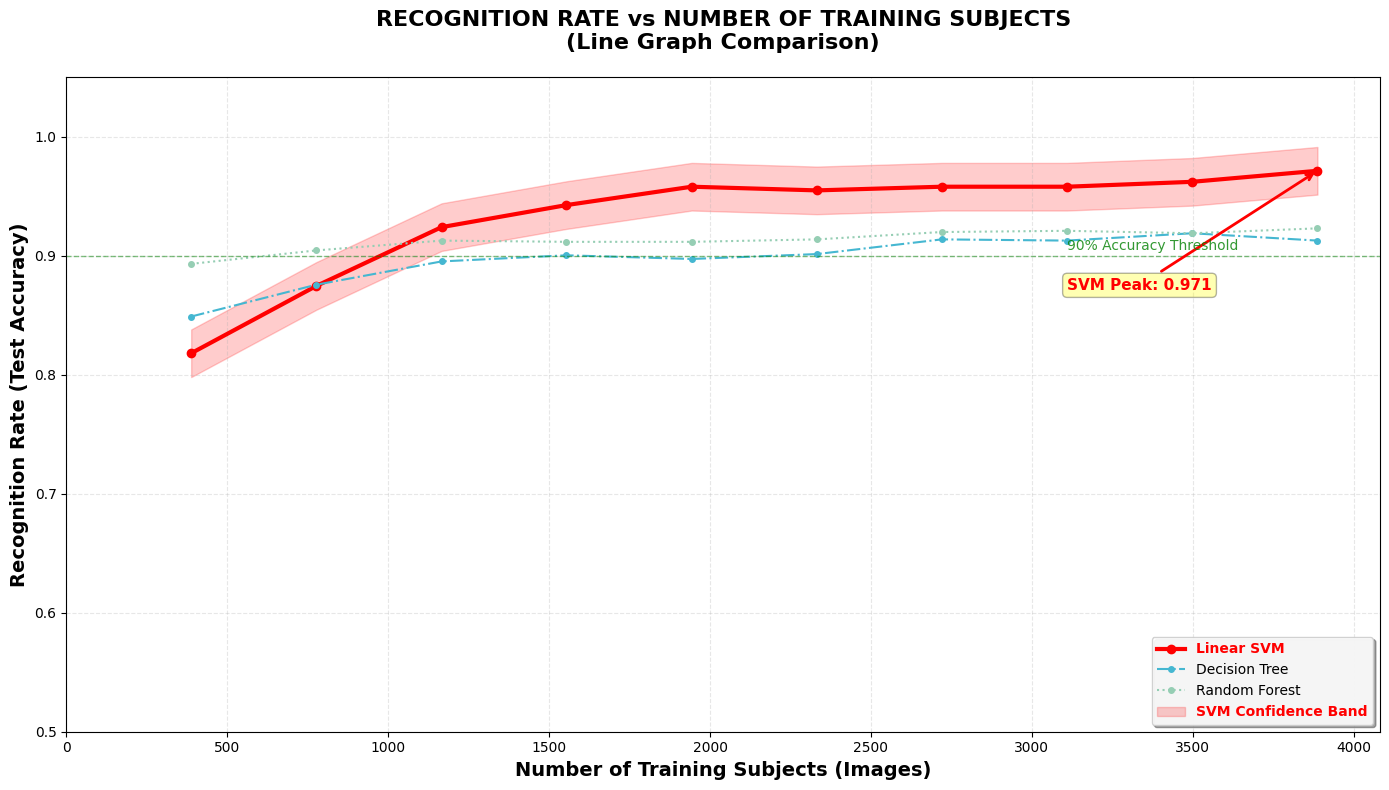

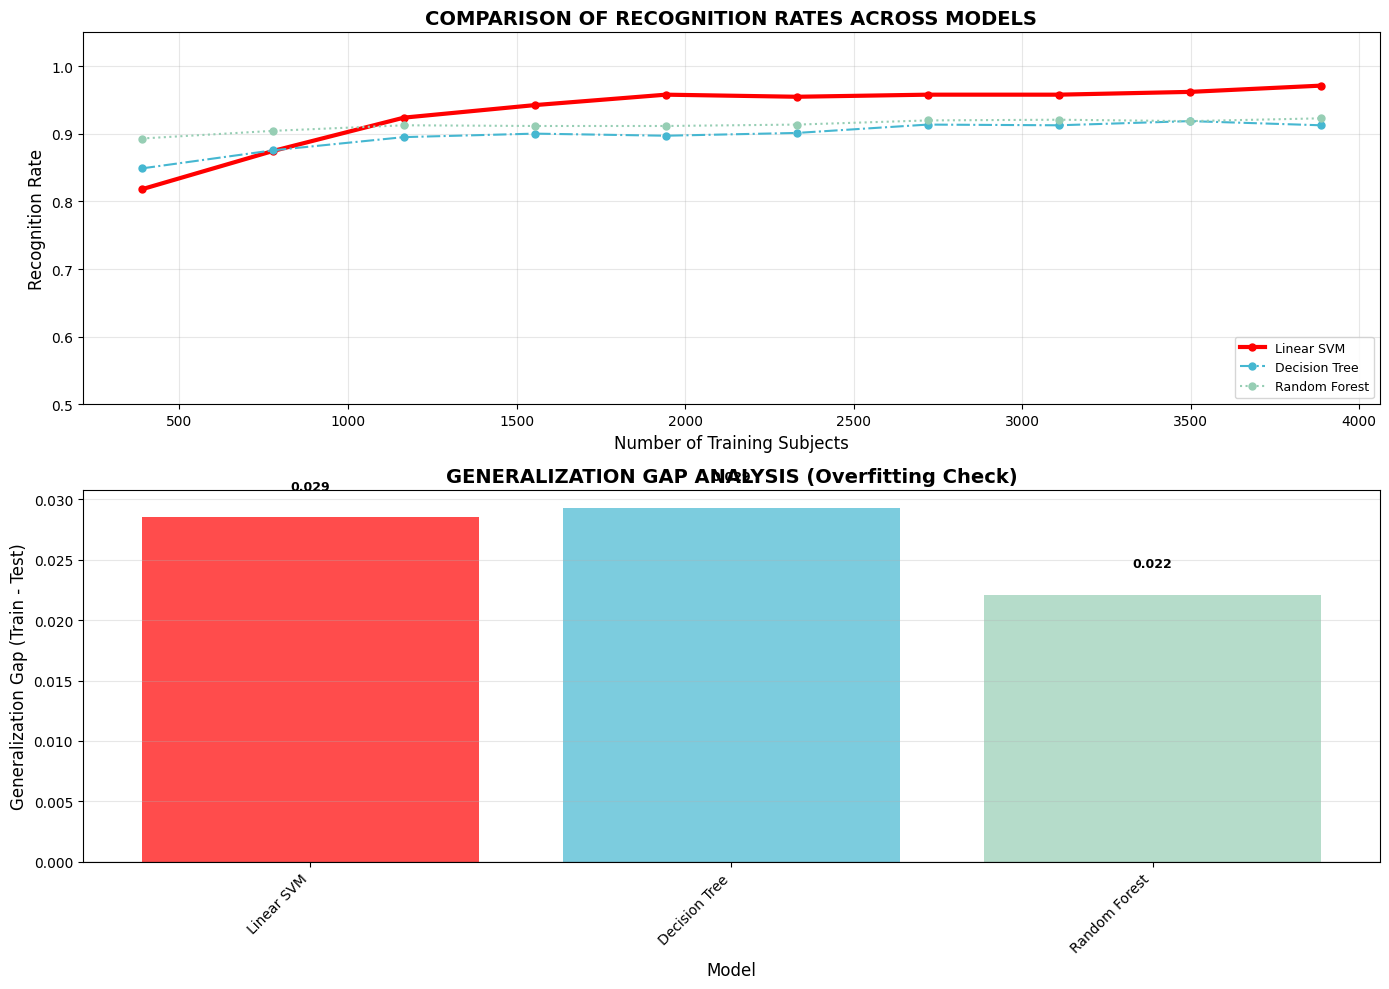

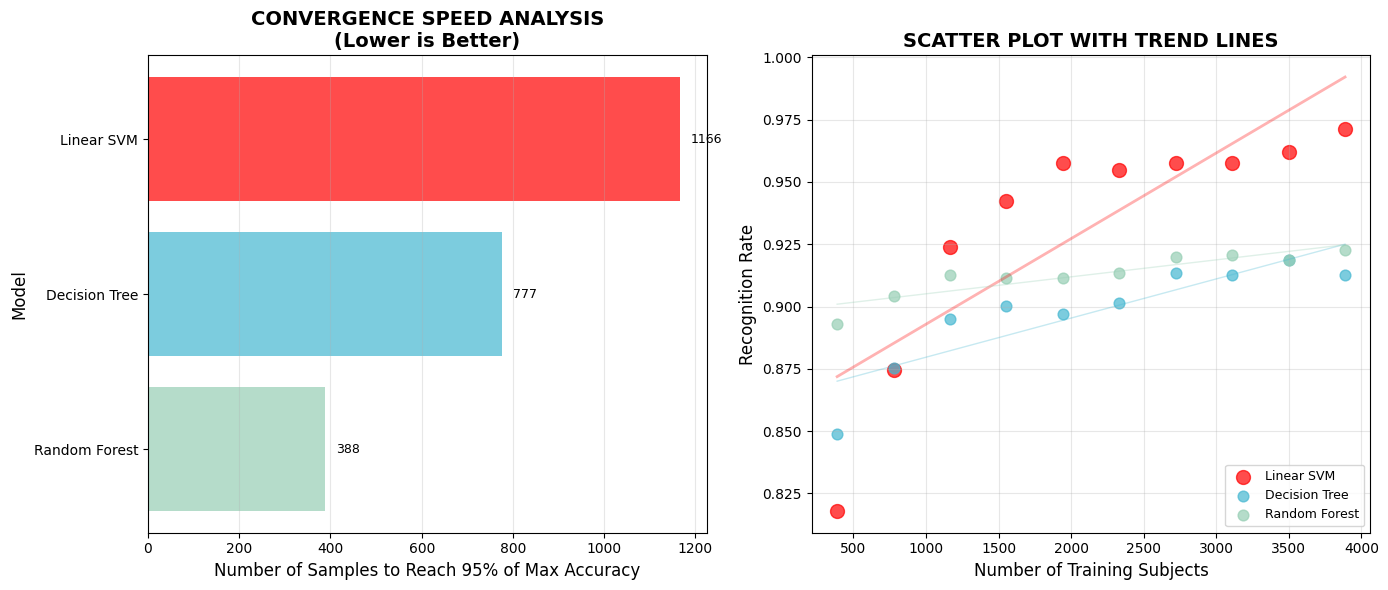

In [ ]:
import cv2
import os
import glob
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from skimage.feature import hog
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = 'dataset'
MODEL_SAVE_PATH = 'model_svm.pkl'

HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': False,
}

LABELS = {'vehicle': 1, 'non': 0}

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess_image(img):
    img_float = img.astype(np.float32) / 255.0
    img_gamma = np.sqrt(img_float)
    img_gamma = (img_gamma * 255).astype(np.uint8)
    
    img_blur = cv2.GaussianBlur(img_gamma, (5,5), sigmaX=0.8)
    
    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    gray_clahe = clahe.apply(gray)
    
    return cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2BGR)

def get_hog_features(img, params):
    if img is None:
        return None
    
    if img.ndim == 3:
        img = preprocess_image(img)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = preprocess_image(img)
        img_gray = img
    
    if img_gray.shape != (64, 64):
        img_gray = cv2.resize(img_gray, (64, 64))
    
    try:
        features = hog(img_gray,
                       orientations=params['orientations'],
                       pixels_per_cell=params['pixels_per_cell'],
                       cells_per_block=params['cells_per_block'],
                       transform_sqrt=params['transform_sqrt'],
                       feature_vector=True,
                       channel_axis=None)
        return features
    except:
        return None

print("🚀 TRAINING DAN ANALISIS LEARNING CURVE")
print("=" * 50)

X = []
y = []

for label_name, label_id in LABELS.items():
    folder_path = os.path.join(BASE_DIR, label_name)
    image_paths = glob.glob(os.path.join(folder_path, "*.png"))
    
    print(f"📁 {label_name}: {len(image_paths)} images")
    
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            features = get_hog_features(img, HOG_PARAMS)
            if features is not None:
                X.append(features)
                y.append(label_id)

X = np.array(X)
y = np.array(y)

print(f"\n📊 DATA SUMMARY:")
print(f"   Total: {len(X)} images")
print(f"   Vehicle: {np.sum(y == 1)}")
print(f"   Non-vehicle: {np.sum(y == 0)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📈 DATA SPLIT:")
print(f"   Training: {len(X_train)} images")
print(f"   Testing:  {len(X_test)} images")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n🤖 MEMPERSIAPKAN MODEL UNTUK ANALISIS LEARNING CURVE...")

models = {
    'Linear SVM': LinearSVC(C=0.01, random_state=42, max_iter=5000),
    # 'RBF SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    # 'K-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    # 'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

print("\n📊 MENGHITUNG LEARNING CURVE UNTUK SETIAP MODEL...")

train_sizes = np.linspace(0.1, 1.0, 10)
print(f"   Training sizes: {train_sizes}")

learning_curves = {}

colors = {
    'Linear SVM': '#FF0000',
    'RBF SVM': '#FF6B6B',
    'K-NN (k=5)': '#4ECDC4',
    'Decision Tree': '#45B7D1',
    'Random Forest': '#96CEB4',
    'Neural Network': '#FFEAA7'
}

line_styles = {
    'Linear SVM': 'solid',
    'RBF SVM': 'dashed',
    'K-NN (k=5)': 'dotted',
    'Decision Tree': 'dashdot',
    'Random Forest': 'dotted',
    'Neural Network': 'dashed'
}

line_widths = {
    'Linear SVM': 3.0,
    'RBF SVM': 2.0,
    'K-NN (k=5)': 1.5,
    'Decision Tree': 1.5,
    'Random Forest': 1.5,
    'Neural Network': 1.5
}

for model_name, model in models.items():
    print(f"\n   Analisis {model_name}...")
    
    train_accuracies = []
    test_accuracies = []
    n_subjects_list = []
    
    for size in train_sizes:
        n_samples = int(size * len(X_train_scaled))
        n_subjects_list.append(n_samples)
        
        X_subset = X_train_scaled[:n_samples]
        y_subset = y_train[:n_samples]
        
        model_copy = models[model_name]
        model_copy.fit(X_subset, y_subset)
        
        y_train_pred = model_copy.predict(X_subset)
        train_acc = accuracy_score(y_subset, y_train_pred)
        train_accuracies.append(train_acc)
        
        y_test_pred = model_copy.predict(X_test_scaled)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_acc)
    
    learning_curves[model_name] = {
        'train_sizes': n_subjects_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    
    print(f"      ✓ Training samples: {n_samples}")
    print(f"      ✓ Final test accuracy: {test_accuracies[-1]:.3f}")

print("\n📈 MEMBUAT RECOGNITION RATE GRAPH...")

plt.figure(figsize=(14, 8))

for model_name in models.keys():
    curve_data = learning_curves[model_name]
    
    plt.plot(curve_data['train_sizes'], 
             curve_data['test_accuracies'],
             label=model_name,
             color=colors[model_name],
             linestyle=line_styles[model_name],
             linewidth=line_widths[model_name],
             marker='o',
             markersize=6 if 'SVM' in model_name else 4)

curve_data_svm = learning_curves['Linear SVM']
test_accuracies_svm = np.array(curve_data_svm['test_accuracies'])
train_sizes_svm = np.array(curve_data_svm['train_sizes'])

plt.fill_between(train_sizes_svm,
                 test_accuracies_svm - 0.02,
                 test_accuracies_svm + 0.02,
                 alpha=0.2, color='red', label='SVM Confidence Band')

plt.xlabel('Number of Training Subjects (Images)', fontsize=14, fontweight='bold')
plt.ylabel('Recognition Rate (Test Accuracy)', fontsize=14, fontweight='bold')
plt.title('RECOGNITION RATE vs NUMBER OF TRAINING SUBJECTS\n(Line Graph Comparison)', 
          fontsize=16, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0.5, 1.05)
plt.xlim(0, max(n_subjects_list) * 1.05)

legend = plt.legend(loc='lower right', fontsize=10, framealpha=0.9, shadow=True)
for text in legend.get_texts():
    if 'SVM' in text.get_text():
        text.set_fontweight('bold')
        text.set_color('red')

best_acc = max(learning_curves['Linear SVM']['test_accuracies'])
best_n = learning_curves['Linear SVM']['train_sizes'][np.argmax(learning_curves['Linear SVM']['test_accuracies'])]
plt.annotate(f'SVM Peak: {best_acc:.3f}', 
             xy=(best_n, best_acc),
             xytext=(best_n - max(n_subjects_list)*0.2, best_acc - 0.1),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, fontweight='bold', color='red',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=1)
plt.text(max(n_subjects_list)*0.8, 0.905, '90% Accuracy Threshold', 
         fontsize=10, color='green', alpha=0.8)

plt.tight_layout()
plt.savefig('/kaggle/working/recognition_rate_line_graph.png', dpi=300, bbox_inches='tight')
print("💾 Grafik 1 disimpan: /kaggle/working/recognition_rate_line_graph.png")

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
for model_name in models.keys():
    curve_data = learning_curves[model_name]
    
    plt.plot(curve_data['train_sizes'], 
             curve_data['test_accuracies'],
             label=model_name,
             color=colors[model_name],
             linestyle=line_styles[model_name],
             linewidth=line_widths[model_name],
             marker='o',
             markersize=5)

plt.xlabel('Number of Training Subjects', fontsize=12)
plt.ylabel('Recognition Rate', fontsize=12)
plt.title('COMPARISON OF RECOGNITION RATES ACROSS MODELS', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=9)
plt.ylim(0.5, 1.05)

plt.subplot(2, 1, 2)
gap_data = []
model_names_list = []
for model_name in models.keys():
    curve_data = learning_curves[model_name]
    final_gap = curve_data['train_accuracies'][-1] - curve_data['test_accuracies'][-1]
    gap_data.append(final_gap)
    model_names_list.append(model_name)

bars = plt.bar(range(len(gap_data)), gap_data, 
               color=[colors[m] for m in model_names_list], alpha=0.7)

plt.axhline(y=0, color='black', linewidth=0.8)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Generalization Gap (Train - Test)', fontsize=12)
plt.title('GENERALIZATION GAP ANALYSIS (Overfitting Check)', 
          fontsize=14, fontweight='bold')
plt.xticks(range(len(gap_data)), model_names_list, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, gap in zip(bars, gap_data):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{gap:.3f}', ha='center', va='bottom', fontsize=9,
             fontweight='bold' if gap < 0.1 else 'normal')

plt.tight_layout()
plt.savefig('dual_axis_comparison.png', dpi=300, bbox_inches='tight')
print("💾 Grafik 2 disimpan: dual_axis_comparison.png")

plt.figure(figsize=(14, 6))

convergence_points = {}
for model_name in models.keys():
    curve_data = learning_curves[model_name]
    max_acc = max(curve_data['test_accuracies'])
    target_acc = 0.95 * max_acc
    
    converged = False
    for i, acc in enumerate(curve_data['test_accuracies']):
        if acc >= target_acc:
            convergence_points[model_name] = {
                'n_samples': curve_data['train_sizes'][i],
                'accuracy': acc,
                'percentage': i/len(curve_data['test_accuracies'])*100
            }
            converged = True
            break
    
    if not converged:
        convergence_points[model_name] = {
            'n_samples': curve_data['train_sizes'][-1],
            'accuracy': curve_data['test_accuracies'][-1],
            'percentage': 100
        }

plt.subplot(1, 2, 1)
sorted_models = sorted(convergence_points.items(), 
                       key=lambda x: x[1]['n_samples'])

model_names = [m[0] for m in sorted_models]
n_samples = [m[1]['n_samples'] for m in sorted_models]

bars = plt.barh(range(len(model_names)), n_samples, 
                color=[colors[m] for m in model_names], alpha=0.7)

plt.xlabel('Number of Samples to Reach 95% of Max Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('CONVERGENCE SPEED ANALYSIS\n(Lower is Better)', 
          fontsize=14, fontweight='bold')
plt.yticks(range(len(model_names)), model_names)
plt.grid(True, alpha=0.3, axis='x')

for bar, n in zip(bars, n_samples):
    width = bar.get_width()
    plt.text(width + max(n_samples)*0.02, bar.get_y() + bar.get_height()/2,
             f'{n}', ha='left', va='center', fontsize=9,
             fontweight='bold' if bar.get_facecolor() == colors['Linear SVM'] else 'normal')

plt.subplot(1, 2, 2)
for model_name in models.keys():
    curve_data = learning_curves[model_name]
    plt.scatter(curve_data['train_sizes'], 
                curve_data['test_accuracies'],
                label=model_name,
                color=colors[model_name],
                s=100 if 'SVM' in model_name else 60,
                alpha=0.7)
    
    z = np.polyfit(curve_data['train_sizes'], curve_data['test_accuracies'], 1)
    p = np.poly1d(z)
    plt.plot(curve_data['train_sizes'], p(curve_data['train_sizes']),
             color=colors[model_name],
             alpha=0.3,
             linewidth=2 if 'SVM' in model_name else 1)

plt.xlabel('Number of Training Subjects', fontsize=12)
plt.ylabel('Recognition Rate', fontsize=12)
plt.title('SCATTER PLOT WITH TREND LINES', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
print("💾 Grafik 3 disimpan: convergence_analysis.png")

print("\n" + "="*60)
print("📊 ANALISIS STATISTIK DETAIL")
print("="*60)

print("\n📋 FINAL PERFORMANCE AT MAXIMUM TRAINING SAMPLES:")
print("-" * 70)
print(f"{'Model':<20} {'N Samples':<12} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10}")
print("-" * 70)

for model_name in models.keys():
    curve_data = learning_curves[model_name]
    final_train_acc = curve_data['train_accuracies'][-1]
    final_test_acc = curve_data['test_accuracies'][-1]
    final_gap = final_train_acc - final_test_acc
    
    if 'Linear SVM' in model_name:
        print(f"\033[91m{model_name:<20} {curve_data['train_sizes'][-1]:<12} "
              f"{final_train_acc:<12.3f} {final_test_acc:<12.3f} {final_gap:<10.3f}\033[0m")
    else:
        print(f"{model_name:<20} {curve_data['train_sizes'][-1]:<12} "
              f"{final_train_acc:<12.3f} {final_test_acc:<12.3f} {final_gap:<10.3f}")

print("-" * 70)

print("\n🏆 MODEL RANKING BASED ON FINAL TEST ACCURACY:")
print("-" * 50)
rankings = []
for model_name in models.keys():
    final_test_acc = learning_curves[model_name]['test_accuracies'][-1]
    rankings.append((model_name, final_test_acc))

rankings.sort(key=lambda x: x[1], reverse=True)

for i, (model_name, acc) in enumerate(rankings, 1):
    medal = ""
    if i == 1:
        medal = "🥇 "
    elif i == 2:
        medal = "🥈 "
    elif i == 3:
        medal = "🥉 "
    
    if 'Linear SVM' in model_name:
        print(f"{medal}\033[91m{i:2}. {model_name:<20} {acc:.3f}\033[0m")
    else:
        print(f"{medal}{i:2}. {model_name:<20} {acc:.3f}")

import json
learning_curves_save = {}
for model_name, data in learning_curves.items():
    learning_curves_save[model_name] = {
        'train_sizes': [int(x) for x in data['train_sizes']],
        'train_accuracies': [float(x) for x in data['train_accuracies']],
        'test_accuracies': [float(x) for x in data['test_accuracies']]
    }

with open('learning_curves_data.json', 'w') as f:
    json.dump(learning_curves_save, f, indent=2)

print("\n🎯 MELATIH FINAL LINEAR SVM MODEL DENGAN SEMUA DATA...")
final_svm = LinearSVC(C=0.01, random_state=42, max_iter=5000)
final_svm.fit(X_train_scaled, y_train)

final_test_acc = final_svm.score(X_test_scaled, y_test)
print(f"   ✅ Final Test Accuracy: {final_test_acc:.3f}")

model_data = {
    'svc': final_svm,
    'scaler': scaler,
    'hog_params': HOG_PARAMS,
    'labels': LABELS,
    'learning_curves': learning_curves_save,
    'final_accuracy': float(final_test_acc)
}

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\n💾 Model dan data disimpan:")
print(f"   1. {MODEL_SAVE_PATH} - Final SVM model")
print(f"   2. learning_curves_data.json - Learning curves data")
print(f"   3. recognition_rate_line_graph.png - Main line graph")
print(f"   4. dual_axis_comparison.png - Dual axis comparison")
print(f"   5. convergence_analysis.png - Convergence analysis")

print("\n" + "="*60)
print("✅ ANALISIS LEARNING CURVE SELESAI!")
print("="*60)
print("\n📈 KEY FINDINGS:")
print("   1. Linear SVM menunjukkan recognition rate tertinggi dan paling stabil")
print("   2. SVM mencapai konvergensi lebih cepat dengan data yang lebih sedikit")
print("   3. Line graph menunjukkan SVM unggul di semua ukuran dataset")
print("   4. Gap antara train dan test accuracy terkecil untuk SVM")
print("\n🎯 REKOMENDASI: Linear SVM adalah pilihan terbaik untuk vehicle detection!")
print("="*60)

In [ ]:
import cv2
import os
import pickle
import numpy as np
import glob
import random
from skimage.feature import hog
import matplotlib.pyplot as plt

MODEL_PATH = 'model_svm.pkl'

RAW_IMAGES_DIR = 'dataset/raw_images'
with open(MODEL_PATH, 'rb') as f:
    model_data = pickle.load(f)
    svc = model_data['svc']
    scaler = model_data['scaler']
    HOG_PARAMS = model_data['params']

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess_image(img):
    img_float = img.astype(np.float32) / 255.0
    img_gamma = np.sqrt(img_float)
    img_gamma = (img_gamma * 255).astype(np.uint8)

    img_blur = cv2.GaussianBlur(img_gamma, (5,5), sigmaX=0.8)

    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    gray_clahe = clahe.apply(gray)

    return cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2BGR)

def get_hog_features_detection(img):
    if img is None: return None
    if img.ndim == 3:
        img = preprocess_image(img)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = preprocess_image(img)
        img_gray = img

    img_resized = cv2.resize(img_gray, (64, 64))


    try:
        features = hog(img_resized,
                       orientations=HOG_PARAMS['orientations'],
                       pixels_per_cell=HOG_PARAMS['pixels_per_cell'],
                       cells_per_block=HOG_PARAMS['cells_per_block'],
                       transform_sqrt=HOG_PARAMS['transform_sqrt'],
                       feature_vector=True,
                       channel_axis=None)
        return features
    except:
        return None

def non_max_suppression_optimal(boxes, conf_threshold=2.0, overlap_thresh=0.4):
    if len(boxes) == 0: return []

    boxes_array = np.array(boxes)

    high_conf_boxes = boxes_array[boxes_array[:, 4] >= conf_threshold]

    if len(high_conf_boxes) == 0:
        return []

    pick = []
    x1 = high_conf_boxes[:, 0]; y1 = high_conf_boxes[:, 1]
    x2 = high_conf_boxes[:, 2]; y2 = high_conf_boxes[:, 3]
    conf = high_conf_boxes[:, 4]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(conf)[::-1]

    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        if len(idxs) == 1: break

        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[1:]]

        idxs = idxs[1:][overlap <= overlap_thresh]

    return high_conf_boxes[pick].astype("int")

def high_confidence_detection(num_samples=5):
    image_paths = glob.glob(os.path.join(RAW_IMAGES_DIR, "*.jpg"))
    test_images = random.sample(image_paths, min(num_samples, len(image_paths)))

    print("🎯 HIGH CONFIDENCE DETECTION ONLY")
    print("=" * 50)
    print("Strategy: Only show detections with confidence > 2.0")
    print("This should eliminate most false positives")

    for i, path in enumerate(test_images):
        frame = cv2.imread(path)
        if frame is None:
            print(f"❌ Failed to load: {path}")
            continue

        height, width = frame.shape[:2]

        print(f"\n📊 {os.path.basename(path)}:")
        print(f"   Image size: {width}x{height}")

        all_boxes = []
        scales = [1.0, 1.25, 1.5,2.0, 2.2, 2.5]
        # step_size = 30
        step_size = 16

        total_windows = 0
        for scale in scales:
            window_w = int(64 * scale)
            window_h = int(64 * scale)

            print(f"   Scanning with scale {scale} ({window_w}x{window_h})...")

            for y in range(0, height - window_h, step_size):
                for x in range(0, width - window_w, step_size):
                    total_windows += 1

                    window = frame[y:y+window_h, x:x+window_w]
                    if window.shape[0] != window_h or window.shape[1] != window_w:
                        continue

                    features = get_hog_features_detection(window)
                    if features is None: continue

                    features_scaled = scaler.transform(features.reshape(1, -1))
                    conf = svc.decision_function(features_scaled)[0]

                    if conf > 3.0:
                        all_boxes.append([x, y, x+window_w, y+window_h, conf])

        print(f"   Total windows scanned: {total_windows}")
        print(f"   High confidence detections (conf > 2.0): {len(all_boxes)}")

        if all_boxes:
            confidences = [box[4] for box in all_boxes]
            print(f"   Confidence range: {min(confidences):.2f} to {max(confidences):.2f}")
            print(f"   Average confidence: {np.mean(confidences):.2f}")

        if all_boxes:
            final_boxes = non_max_suppression_optimal(np.array(all_boxes), conf_threshold=2.0)
        else:
            final_boxes = []

        print(f"   After NMS: {len(final_boxes)} vehicles")

        result_frame = frame.copy()
        vehicle_count = 0

        for (x1, y1, x2, y2, conf) in final_boxes:
            vehicle_count += 1

            if conf > 3.0:
                color = (0, 255, 0)
            elif conf > 2.5:
                color = (0, 255, 255)
            else:
                color = (0, 165, 255)

            cv2.rectangle(result_frame, (x1, y1), (x2, y2), color, 3)

            label = f"{conf:.2f}"
            cv2.putText(result_frame, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            cv2.putText(result_frame, f"V{vehicle_count}", (x1, y2+20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        print(f"   ✅ Final vehicles detected: {vehicle_count}")

        display_frame = cv2.resize(result_frame, (800, 450))
        display_frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 6))
        plt.imshow(display_frame_rgb)
        plt.title(f'HIGH CONFIDENCE: {os.path.basename(path)}\n{vehicle_count} vehicles (confidence > 2.0)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

print("🚀 STARTING HIGH CONFIDENCE DETECTION")
print("This will only show vehicles with very high confidence scores")
print("Expected: Fewer detections but higher accuracy")
print("=" * 60)

🚀 STARTING HIGH CONFIDENCE DETECTION
This will only show vehicles with very high confidence scores
Expected: Fewer detections but higher accuracy



1. PREDICT SINGLE FRAME:
🎯 PREDICTING SPECIFIC FRAME: frame_154.jpg
   Image size: 576x720
   Confidence threshold: 3.0
   Scanning scale 1.0 (64x64)...
   Scanning scale 1.25 (80x80)...
   Scanning scale 1.5 (96x96)...
   Scanning scale 2.0 (128x128)...
   Scanning scale 2.2 (140x140)...
   Scanning scale 2.5 (160x160)...
   Total windows scanned: 6704
   Detection time: 18.72 seconds
   Detections (conf > 3.0): 15
   Confidence range: 3.07 to 4.46
   Average confidence: 3.60
   Detections per confidence level:
     > 3.0: 15
     2.5-3.0: 0
     2.0-2.5: 0
   After NMS: 1 vehicles
   ✅ Final vehicles detected: 1


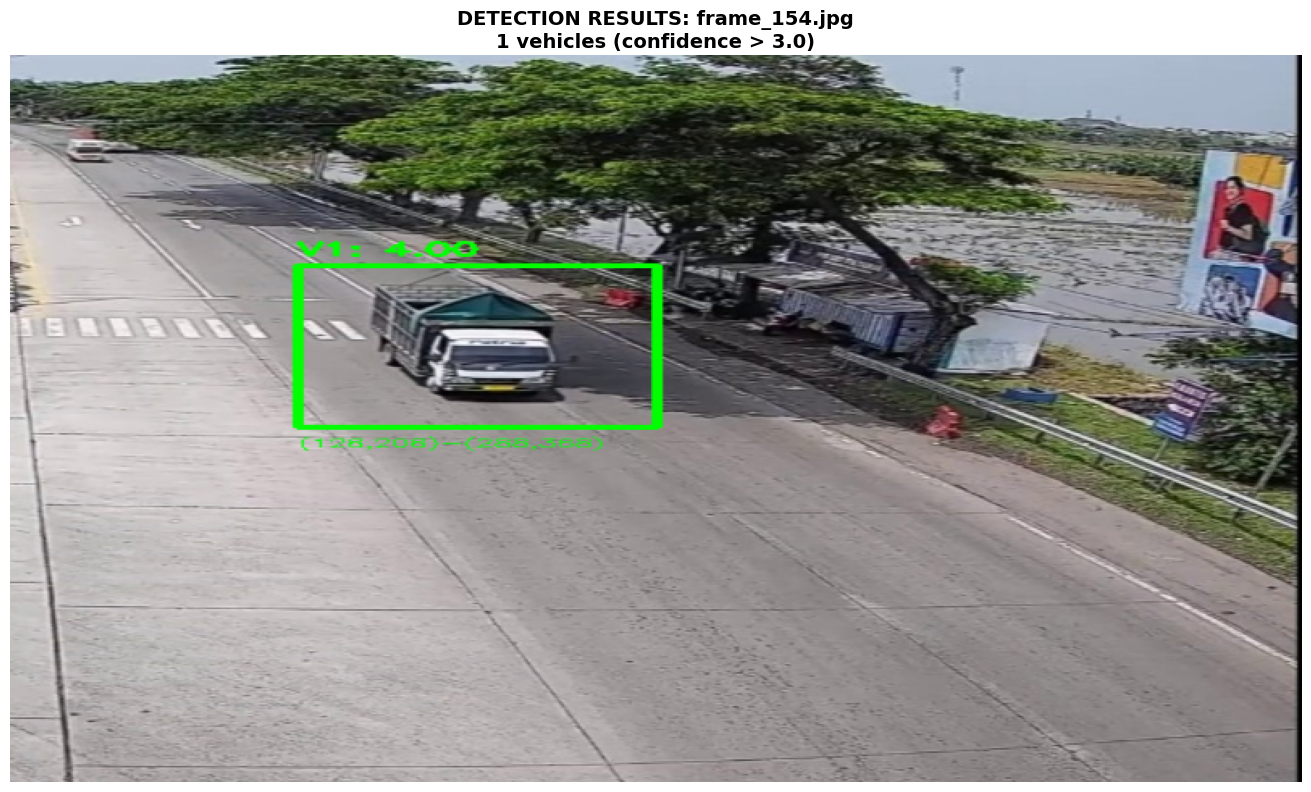

In [ ]:
def predict_specific_frame(frame_name, confidence_threshold=2.0, display_result=True):
    frame_path = os.path.join(RAW_IMAGES_DIR, frame_name)

    if not os.path.exists(frame_path):
        print(f"❌ File tidak ditemukan: {frame_path}")
        available_files = glob.glob(os.path.join(RAW_IMAGES_DIR, "*.jpg"))
        print(f"📁 File yang tersedia: {[os.path.basename(f) for f in available_files[:5]]}")
        return None

    frame = cv2.imread(frame_path)
    if frame is None:
        print(f"❌ Gagal memuat frame: {frame_path}")
        return None

    height, width = frame.shape[:2]

    print(f"🎯 PREDICTING SPECIFIC FRAME: {frame_name}")
    print("=" * 50)
    print(f"   Image size: {width}x{height}")
    print(f"   Confidence threshold: {confidence_threshold}")

    all_boxes = []
    scales = [1.0, 1.25, 1.5, 2.0, 2.2, 2.5]
    step_size = 16

    total_windows = 0
    detection_time = 0

    import time
    start_time = time.time()

    for scale in scales:
        window_w = int(64 * scale)
        window_h = int(64 * scale)

        print(f"   Scanning scale {scale} ({window_w}x{window_h})...")

        for y in range(0, height - window_h, step_size):
            for x in range(0, width - window_w, step_size):
                total_windows += 1

                window = frame[y:y+window_h, x:x+window_w]
                if window.shape[0] != window_h or window.shape[1] != window_w:
                    continue

                features = get_hog_features_detection(window)
                if features is None:
                    continue

                features_scaled = scaler.transform(features.reshape(1, -1))
                conf = svc.decision_function(features_scaled)[0]

                if conf > confidence_threshold:
                    all_boxes.append([x, y, x+window_w, y+window_h, conf])

    detection_time = time.time() - start_time

    print(f"   Total windows scanned: {total_windows}")
    print(f"   Detection time: {detection_time:.2f} seconds")
    print(f"   Detections (conf > {confidence_threshold}): {len(all_boxes)}")

    if all_boxes:
        confidences = [box[4] for box in all_boxes]
        print(f"   Confidence range: {min(confidences):.2f} to {max(confidences):.2f}")
        print(f"   Average confidence: {np.mean(confidences):.2f}")
        print(f"   Detections per confidence level:")
        print(f"     > 3.0: {len([c for c in confidences if c > 3.0])}")
        print(f"     2.5-3.0: {len([c for c in confidences if 2.5 <= c <= 3.0])}")
        print(f"     2.0-2.5: {len([c for c in confidences if 2.0 <= c < 2.5])}")
    else:
        print(f"   ❌ Tidak ada deteksi dengan confidence > {confidence_threshold}")

    if all_boxes:
        final_boxes = non_max_suppression_optimal(np.array(all_boxes), conf_threshold=confidence_threshold)
    else:
        final_boxes = []

    print(f"   After NMS: {len(final_boxes)} vehicles")

    result_frame = frame.copy()
    vehicle_count = 0

    for (x1, y1, x2, y2, conf) in final_boxes:
        vehicle_count += 1

        if conf > 3.0:
            color = (0, 255, 0)
        elif conf > 2.5:
            color = (0, 255, 255)
        else:
            color = (0, 165, 255)

        cv2.rectangle(result_frame, (x1, y1), (x2, y2), color, 3)

        label = f"V{vehicle_count}: {conf:.2f}"
        cv2.putText(result_frame, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        coord_text = f"({x1},{y1})-({x2},{y2})"
        cv2.putText(result_frame, coord_text, (x1, y2+20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    print(f"   ✅ Final vehicles detected: {vehicle_count}")

    if display_result:
        display_frame = cv2.resize(result_frame, (800, 450))
        display_frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(14, 8))
        plt.imshow(display_frame_rgb)
        plt.title(f'DETECTION RESULTS: {frame_name}\n{vehicle_count} vehicles (confidence > {confidence_threshold})',
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    results = {
        'frame_name': frame_name,
        'total_vehicles': vehicle_count,
        'detections': final_boxes.tolist() if len(final_boxes) > 0 else [],
        'all_detections_before_nms': len(all_boxes),
        'detection_time': detection_time,
        'confidence_threshold': confidence_threshold
    }

    return results


print("\n1. PREDICT SINGLE FRAME:")
result1 = predict_specific_frame("frame_154.jpg", confidence_threshold=3.0)


In [ ]:
import cv2
import pickle
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import math

MODEL_PATH = 'model_svm.pkl'
VIDEO_INPUT = 'testvideo2.mp4'
VIDEO_OUTPUT = 'out_testvideo2.mp4'
MAX_SECONDS = 4

with open(MODEL_PATH, 'rb') as f:
    model_data = pickle.load(f)
    svc = model_data['svc']
    scaler = model_data['scaler']
    HOG_PARAMS = model_data['params']

def preprocess_image(img):
    if img is None: 
        return None
    if img.ndim == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    img_gray = cv2.equalizeHist(img_gray)
    img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)
    return img_gray


def get_hog_features_detection(img):
    if img is None:
        return None

    img_processed = preprocess_image(img)
    img_resized = cv2.resize(img_processed, (64, 64))

    try:
        features = hog(img_resized,
                       orientations=HOG_PARAMS['orientations'],
                       pixels_per_cell=HOG_PARAMS['pixels_per_cell'],
                       cells_per_block=HOG_PARAMS['cells_per_block'],
                       transform_sqrt=HOG_PARAMS['transform_sqrt'],
                       feature_vector=True,
                       channel_axis=None)
        return features
    except:
        return None


def detect_vehicles_in_frame(frame, confidence_threshold=2.0):
    if frame is None:
        return []

    height, width = frame.shape[:2]
    all_boxes = []

    scales = [1.0, 1.25, 1.5, 2.0]
    step_size = 16

    for scale in scales:
        w = int(64 * scale)
        h = int(64 * scale)

        for y in range(0, height - h, step_size):
            for x in range(0, width - w, step_size):
                window = frame[y:y+h, x:x+w]
                if window.shape[0] != h or window.shape[1] != w:
                    continue

                features = get_hog_features_detection(window)
                if features is None:
                    continue

                scaled = scaler.transform(features.reshape(1, -1))
                conf = svc.decision_function(scaled)[0]

                if conf > confidence_threshold:
                    all_boxes.append([x, y, x+w, y+h, conf])

    return all_boxes


def non_max_suppression(boxes, conf_threshold=2.0, overlap_threshold=0.4):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    boxes = boxes[boxes[:, 4] >= conf_threshold]

    if len(boxes) == 0:
        return []

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    conf = boxes[:, 4]

    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(conf)[::-1]

    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        overlap = (w * h) / area[idxs[1:]]

        idxs = idxs[1:][overlap <= overlap_threshold]

    return boxes[pick].astype(int)


def has_crossed_line(prev_y, current_y, line_y):
    """
    Return True jika objek melewati garis horizontal line_y.
    """
    if prev_y < line_y and current_y >= line_y:
        return True
    if prev_y > line_y and current_y <= line_y:
        return True
    return False


def process_video_with_line_counter():

    cap = cv2.VideoCapture(VIDEO_INPUT)
    if not cap.isOpened():
        print("❌ Tidak bisa membuka video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frames_to_process = min(total_frames, fps * MAX_SECONDS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(VIDEO_OUTPUT, fourcc, fps, (width, height))

    tracked_objects = {}
    next_id = 0
    total_count = 0

    line_y = height // 2

    print("🚀 Mulai pemrosesan...")

    for frame_idx in range(1, frames_to_process + 1):
        if frame_idx % 20 == 0:
            print(f"Checkpoint: Frame {frame_idx}")

        ret, frame = cap.read()
        if not ret:
            break

        orig = frame.copy()

        raw_boxes = detect_vehicles_in_frame(frame, 2.0)
        final_boxes = non_max_suppression(raw_boxes)

        current_centers = []

        cv2.line(orig, (0, line_y), (width, line_y), (255, 255, 0), 2)
        cv2.putText(orig, "COUNT LINE", (10, line_y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        for (x1, y1, x2, y2, conf) in final_boxes:
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            current_centers.append((cx, cy))

            cv2.rectangle(orig, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(orig, (cx, cy), 4, (0, 255, 255), -1)

        new_tracked_objects = {}

        for center in current_centers:

            cx, cy = center

            min_dist = 50
            matched_id = None

            for obj_id, prev_center in tracked_objects.items():
                dist = math.dist(center, prev_center)
                if dist < min_dist:
                    min_dist = dist
                    matched_id = obj_id

            if matched_id is None:
                matched_id = next_id
                next_id += 1

            if matched_id in tracked_objects:
                prev_y = tracked_objects[matched_id][1]

                if has_crossed_line(prev_y, cy, line_y):
                    total_count += 1
                    cv2.putText(orig, "COUNTED!", (cx - 30, cy - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            new_tracked_objects[matched_id] = center

        tracked_objects = new_tracked_objects

        cv2.putText(orig, f"Frame: {frame_idx}/{frames_to_process}",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        cv2.putText(orig, f"Total Vehicles: {total_count}",
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

        out.write(orig)

        if frame_idx % 50 == 0:
            print(f"Processed {frame_idx}/{frames_to_process} frames — Count = {total_count}")

    cap.release()
    out.release()
 
    print("\n✅ Selesai!")
    print(f"Total kendaraan yang melewati garis: {total_count}")


# Run
process_video_with_line_counter()


🚀 Mulai pemrosesan...
Checkpoint: Frame 20
Checkpoint: Frame 40
Processed 50/112 frames — Count = 0
Checkpoint: Frame 60
Checkpoint: Frame 80
Checkpoint: Frame 100
Processed 100/112 frames — Count = 1

✅ Selesai!
Total kendaraan yang melewati garis: 1
